In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

In [98]:
INPUT='/mnt/c/Users/scl38887/Documents/git/aldehyde/results/dyntrans_full_3H_ws/integrated_comp/stats.csv'
OUTPUT='/mnt/c/Users/scl38887/Documents/git/aldehyde/results/graphics_general' #fix_co2/graphics/integrated_comp/'

In [99]:
def prepare_data(data, zerofilter=False):
    # Prepare the data
    # Extract the Co2L which is in position 5-8
    data["opts"] = data["opts"].str[4:]

    # Rescale the cost from euro to B€
    data["cost"] = data["cost"] / 1e9

    # Round the data
    # to_round = plottype
    # data[to_round] = data[to_round].round(2)

    # Filter the data to remove 0 export and 0 co2 reduction
    print(f"zerofiler is set to {zerofilter} or in boolean {bool(zerofilter)}")
    if zerofilter:
        print("Filtering data")
        #data = data[(data["h2export"] != 0) & (data["opts"] != "2.0")]
        data = data[(data["h2export"] != 0)]

    else:
        pass

    return data


In [100]:
def reshape_data(data, opts, h2export, plottype):
    # Reshape the data for all columns in to_round and save it in data dictionary
    data_reshaped = {}
    # TODO loop is not necessary since I only use one plottype
    for i in [plottype]:
        data_reshaped[i] = data[i].values.reshape(len(opts), len(h2export)).T

    return data_reshaped

In [101]:
def plot_data(ax, data_reshaped, plottype, levels, cmap, title):
    # Turn "limit" to "reduction" (e.g. Co2L0.90 means 10% reduction)
    opts_reverse = 1 - opts
    opts_reverse[opts_reverse < 0] = 0

    # Plot a contour plot of the data having the y-axis the column "h2export", x-axis the column "sopts", and the z-axis the column "cost"
    #fig = plt.figure(figsize=(9, 6))
    contour = ax.contourf(
        opts_reverse * 100,
        h2export,
        np.flip(data_reshaped[plottype], axis=1),
        levels=levels,
        #colors=["green", "red"],
        cmap=cmap,
    )
    plt.colorbar(contour, ax=ax, orientation='vertical')#.set_label("Capacity in GW")
    ax.set_title(title)


    return contour

In [102]:
# Prepare the data
#plottype = "mg_H2_False_False_exportonly"
levels = 20
show_minimums = False
label = "Cost in B€"
zerofilter = True

data = pd.read_csv(INPUT)
data = prepare_data(data, zerofilter=zerofilter)

h2export = np.unique(data["h2export"])
opts = np.unique(
    data["opts"].fillna(100).astype(float)
)  # TODO improve the fillna value

el_base_demand = min(reshape_data(data, opts, h2export, plottype="el_base_demand")["el_base_demand"][0])

#data_reshaped = reshape_data(data, opts, h2export, plottype=plottype)


zerofiler is set to True or in boolean True
Filtering data


### Plot data

In [103]:
def create_cmap(rgb):
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(1, rgb[0]/256, N)
    vals[:, 1] = np.linspace(1, rgb[1]/256, N)
    vals[:, 2] = np.linspace(1, rgb[2]/256, N)
    my_cmap = ListedColormap(vals)
    return my_cmap

In [113]:
params = {"Onshore Wind": {"plottype": "onshore_p_nom_opt", "rgb": [18, 143, 207],     "title": "Onshore Wind"},
               "Solar PV": {"plottype": "pv_p_nom_opt", "rgb": [228, 203, 58], "title": "Solar PV"},
               "Coal": {"plottype": "coal_p_nom_opt", "rgb": [80, 80, 80], "title": "Coal"},
               "OCGT": {"plottype": "ocgt_p_nom_opt", "rgb": [228, 147,44], "title": "OCGT"},
}

In [112]:
data.columns

Index(['h2export', 'opts', 'cost', 'mg_H2_inclu_Fisch_all',
       'mg_H2_exclu_Fisch_all', 'mg_H2_False_False_exportonly',
       'mg_H2_False_False_noexport', 'mg_H2_False_False_all',
       'mg_AC_exclu_H2 El_all', 'mg_AC_inclu_H2 El_all',
       'mg_AC_False_False_all', 'mg_oil_False_False_all',
       'mg_gas_False_False_all', 'lcoh_system', 'H2_GWh', 'Battery_GWh',
       'H2export_GWh', 'ratio_H2_Battery', 'curtailmentrate_solar',
       'curtailmentrate_wind', 'el_base_demand', 'cf_electrolysis', 'pv_capex',
       'pv_p_nom_opt', 'onshore_capex', 'onshore_p_nom_opt', 'coal_capex',
       'coal_p_nom_opt', 'ccgt_capex', 'ccgt_p_nom_opt', 'ror_capex',
       'ror_p_nom_opt', 'oil_capex', 'oil_p_nom_opt', 'ocgt_capex',
       'ocgt_p_nom_opt', 'pv_supply', 'pv_cf', 'onshore_supply', 'onshore_cf',
       'coal_supply', 'coal_cf', 'ccgt_supply', 'ccgt_cf', 'ror_supply',
       'ror_cf', 'oil_supply', 'oil_cf', 'ocgt_supply', 'ocgt_cf', 'ft_capex',
       'ft_p_nom_opt', 'ft_supply'

In [110]:
def subplot(pos, title):

    data_reshaped = reshape_data(data, opts, h2export, plottype=params[title]["plottype"])
    plot = plot_data(pos, data_reshaped, params[title]["plottype"], 7, cmap=create_cmap(params[title]["rgb"]), title=title)

    return plot

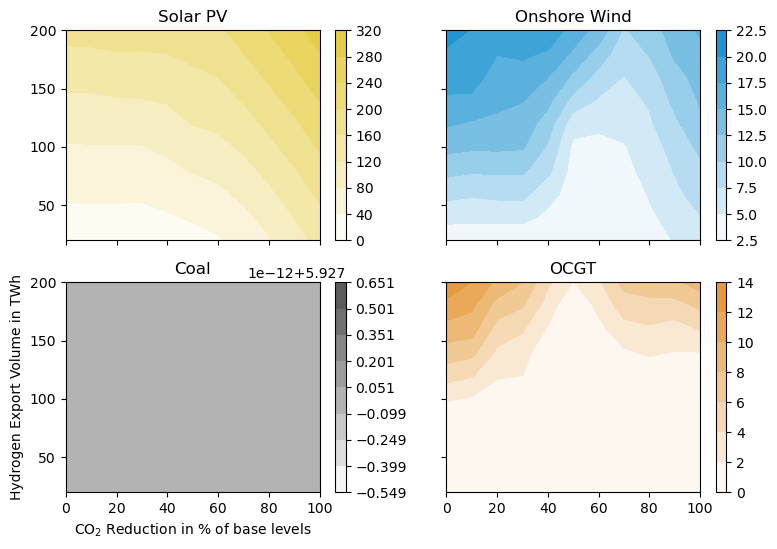

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharex=True, sharey=True)

# Add x- and y-labels
axes[1,0].set_xlabel("CO$_2$ Reduction in % of base levels")
axes[1,0].set_ylabel("Hydrogen Export Volume in TWh")

# Create subplots
title = "Onshore Wind"
subplot(axes[0,1], title)

title = "Solar PV"
subplot(axes[0,0], title)

title = "Coal"
subplot(axes[1,0], title)

title = "OCGT"
subplot(axes[1,1], title)

# Colorbar outsite function
#fig.colorbar(plot, ax=axes[1, 1], orientation='vertical').set_label("Capacity in GW")

# Secondary y-axis
# ax2 = plt.gca().twinx()
# h2export_secondary = h2export / el_base_demand
# ax2.set_ylabel("H2-Exp/El-base-demand")
# ax2.set_ylim(0, max(h2export_secondary))  # Adjust the limit based on your data

plt.show()